## 4.1 Evaluation metrics: session overview

_Metric_ - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/refs/heads/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.columns = df.columns.str.lower().str.replace(" ", "_")
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')


df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']


In [55]:
dv = DictVectorizer(sparse=False)

train_dicts=df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(max_iter=2020)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2030)

In [7]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

np.int64(1132)

In [10]:
#Accuracy (in this case is the same as mean) 
1132/1409

0.8034066713981547

In [11]:
#we can move our threshold

threshholds = np.linspace(0, 1, 21)
scores = []

for t in threshholds:
    churn_decision = (y_pred >=t)
    score = (y_val == churn_decision).mean()
    scores.append(score)
    print("%.2f  %.3f" % (t, score))

0.00  0.274
0.05  0.509
0.10  0.591
0.15  0.666
0.20  0.710
0.25  0.739
0.30  0.760
0.35  0.772
0.40  0.785
0.45  0.793
0.50  0.803
0.55  0.801
0.60  0.795
0.65  0.786
0.70  0.766
0.75  0.744
0.80  0.735
0.85  0.726
0.90  0.726
0.95  0.726
1.00  0.726


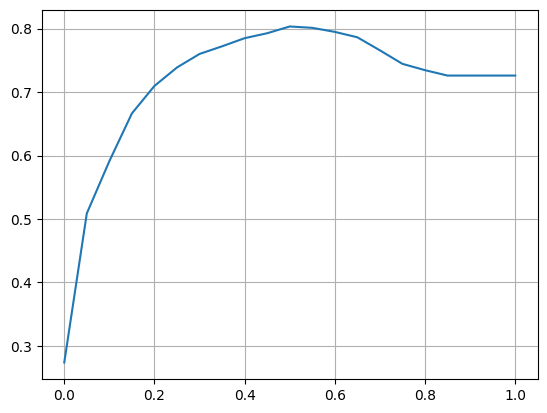

In [12]:
fix, ax = plt.subplots()
ax.plot(threshholds, scores)
ax.grid()

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [15]:
threshholds = np.linspace(0, 1, 21)
scores = []

for t in threshholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)
    print("%.2f  %.3f" % (t, score))

0.00  0.274
0.05  0.509
0.10  0.591
0.15  0.666
0.20  0.710
0.25  0.739
0.30  0.760
0.35  0.772
0.40  0.785
0.45  0.793
0.50  0.803
0.55  0.801
0.60  0.795
0.65  0.786
0.70  0.766
0.75  0.744
0.80  0.735
0.85  0.726
0.90  0.726
0.95  0.726
1.00  0.726


In [16]:
y_pred >= 1.0

array([False, False, False, ..., False, False, False])

In [17]:
from collections import Counter

In [18]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

Our Dummy model is 73% accurate

while our model is 80% accurate

In [19]:
y_val

array([0, 0, 0, ..., 0, 1, 1])

In [20]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

Class imbalance 3:1 ratio b/c there are three more times non-churning customers than churning

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table
  

True positive - correct prediction of churn
True negative - correct prediction of no - churn

False positive = customer predicted to churn, but did not churn
False negative = customer predicted not to churn, but churned


In [21]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)


In [22]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [23]:
predict_positive[:5]

array([False, False, False,  True, False])

In [24]:
actual_positive[:5] #at 12:10 in video

array([False, False, False,  True, False])

In [25]:
tp = (predict_positive & actual_positive).sum() #element-vise logical AND
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [26]:
print(fp.sum())
print(fn.sum())

101
176


Predictions


In [27]:
confusion_matrix = np.array([[tn, fp],
                           [fn, tp]])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [28]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

Accuracy = 80% = 65% + 15% 

## 4.4 Precision and Recall

In [29]:
(tp + tn)/(tp + tn + fp + fn)

np.float64(0.8034066713981547)

__Precision__ = what fraction of positive predictions are correct!

out of four people positively predicted - one was false positive therefore our precision is 3/4 = 75%

**Precision** 
$$Precision=TP/(TP+FP)$$

In [30]:
p = tp/(tp+fp)
print(f"Precision:{round(p, 2)}%")

Precision:0.68%


__RECALL__ - fraction of correctly identified positive examples

![Recall Chart](recall.png "a title")

**Recall** 
$$Recall=TP/(TP+FN)$$

In [31]:
r= tp/(tp+fn)
print(f"Recall:{round(r, 2)}%")


Recall:0.54%


__Accuracy 80%__ which seems high, but when we look at precision and recall - we failed to id 45% who are going to churn

_accuracy is misleading, especially when you have __class imbalance___


![Precision Recall Accuracy](precision_recall_accuracy.jpg "Precision Recall Accuracy")

## 4.5 ROC Curves
Receiving Operating Characteristics

(WWII for evaluating strength of radar)

FPR - false positive rate

TPR - true positive rate

$$ FPR = FP/(TN+FP)$$

$$TPR = TP/(FN+TP)$$

![ROC_1](roc_1.png "Precision Recall Accuracy")

#### Recall is the same as True positive rate (TPR)

In [32]:
tpr = tp/(tp+fn)
tpr

np.float64(0.5440414507772021)

In [33]:
fpr=fp/(fp+tn)
fpr

np.float64(0.09872922776148582)

Let's compute these values for all possible thresholds

In [34]:
thesholds = np.linspace(0, 1, 101)
len(thesholds)

101

In [35]:
scores = []

for t in thesholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum() #element-vise logical AND
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, fp, fn, tn))
len(scores)

101

In [36]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10] #this will return (display) every 10th record

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [37]:
df_scores.count()

threshold    101
tp           101
fp           101
fn           101
tn           101
dtype: int64